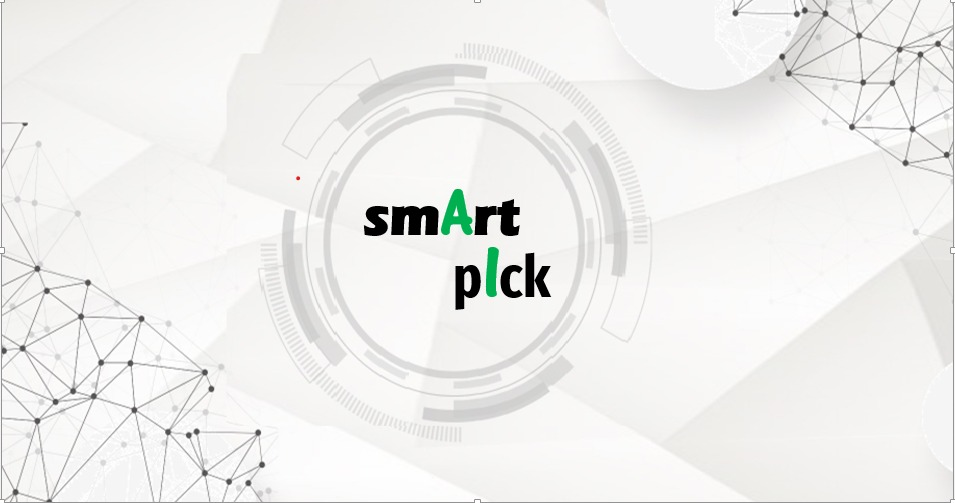

In [1]:
!git clone https://github.com/HadiHas/Apple_Detection_Repo.git

Cloning into 'Apple_Detection_Repo'...
remote: Enumerating objects: 1045, done.
remote: Counting objects: 100% (1045/1045), done.
remote: Compressing objects: 100% (1025/1025), done.
remote: Total 1045 (delta 23), reused 1038 (delta 18), pack-reused 0
Receiving objects: 100% (1045/1045), 9.79 MiB | 36.45 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [2]:
# load modules
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, AveragePooling2D
from google.colab.patches import cv2_imshow

In [161]:
# create iterators
datagen = ImageDataGenerator(rotation_range=25) #vertical_flip=True, rotation_range=25, brightness_range=[0.2, 1.3], width_shift_range=[-10,10], height_shift_range=0.5
train_it = datagen.flow_from_directory("Apple_Detection_Repo/apple_dataset_2_Cat_Clean/train", target_size=(256, 256), class_mode="binary", batch_size=20)
test_it = datagen.flow_from_directory("Apple_Detection_Repo/apple_dataset_2_Cat_Clean/test",  target_size=(256, 256), class_mode="binary", batch_size=10)

Found 305 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [110]:
print('Batches train=%d, test=%d' % (len(train_it), len(test_it)))

Batches train=16, test=10


In [86]:
def ShowImage(img):
  b,g,r = cv2.split(img)
  img = cv2.merge((r,g,b))
  cv2_imshow(img)

Batch shape=(20, 256, 256, 3), min=0.000, max=255.000


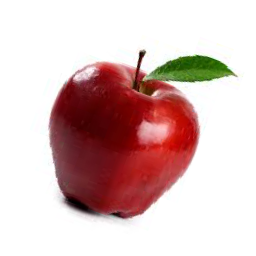

In [162]:
# confirm the scaling works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

ShowImage(batchX[0])


In [268]:
# create model CNN
model = Sequential()
model.add(Conv2D(4, (3,3), input_shape=(256, 256, 3), activation="relu"))
model.add(AveragePooling2D())
model.add(Conv2D(8, (3,3), activation="relu"))
model.add(AveragePooling2D())
model.add(Conv2D(10, (3,3), activation="relu"))
model.add(AveragePooling2D())
# from 3d to 1d
model.add(Flatten())
 
# create model DNN
model.add(Dense(150, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
 
# print module summary
model.summary()
 
# compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
 
#train the model
steps = len(train_it)/2 
model.fit(train_it, epochs=15, steps_per_epoch= steps, validation_data=test_it)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 254, 254, 4)       112       
_________________________________________________________________
average_pooling2d_90 (Averag (None, 127, 127, 4)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 125, 125, 8)       296       
_________________________________________________________________
average_pooling2d_91 (Averag (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 60, 60, 10)        730       
_________________________________________________________________
average_pooling2d_92 (Averag (None, 30, 30, 10)        0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 9000)            

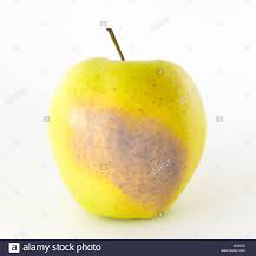

Bad 1: 0.014090


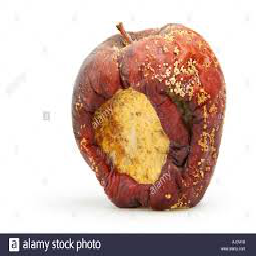

Bad 2: 0.001334


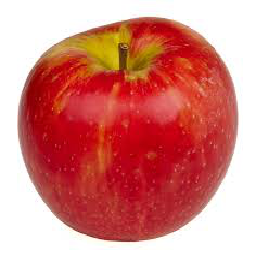

Good 1: 0.999831


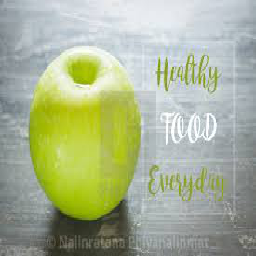

Good 2: 0.419856


In [269]:
# example of using a pre-trained model as a classifier
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# load an image from file
image = load_img("Apple_Detection_Repo/apple_dataset_2_Cat/To_Predict/damaged_apple (115).jpg", target_size=(256, 256)) #0.3
image = img_to_array(image)
ShowImage(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
yhat = model.predict(image)
# convert the probabilities to class labe
print("Bad 1: %f" % yhat[0][0])

image = load_img("Apple_Detection_Repo/apple_dataset_2_Cat/To_Predict/damaged_apple (125).jpg", target_size=(256, 256)) #0.4
image = img_to_array(image)
ShowImage(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
yhat = model.predict(image)
# convert the probabilities to class labe
print("Bad 2: %f" % yhat[0][0])

image = load_img("Apple_Detection_Repo/apple_dataset_2_Cat/To_Predict/apple (60).jpg", target_size=(256, 256)) #0.9
image = img_to_array(image)
ShowImage(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
yhat = model.predict(image)
# convert the probabilities to class labe
print("Good 1: %f" % yhat[0][0])

image = load_img("Apple_Detection_Repo/apple_dataset_2_Cat/To_Predict/apple (23).jpg", target_size=(256, 256)) #0.4
image = img_to_array(image)
ShowImage(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
yhat = model.predict(image)
# convert the probabilities to class labe
print("Good 2: %f" % yhat[0][0])


In [181]:
from PIL import Image
import requests

def prepareToPredict(url):
  desired_size = 256
  img = Image.open(requests.get(url, stream=True).raw)
  old_size = img.size  # old_size[0] is in (width, height) format
  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  img = img.resize(new_size, Image.ANTIALIAS)
  new_im = Image.new("RGB", (desired_size, desired_size), (255,255,255))
  new_im.paste(img, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
  image = img_to_array(new_im)
  ShowImage(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  return image

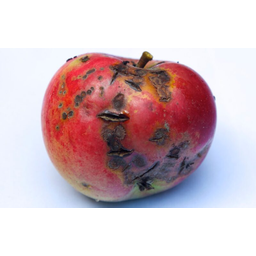

Prediction 1: 0.196361


In [270]:
url1 = 'https://apologyanalogy.com/wp-content/uploads/2019/03/rotten-apple-picture-id179349587-1-800x500.jpg' # Bad
image1 = prepareToPredict(url1)
yhat1 = model.predict(image1)
print("Prediction 1: %f" % yhat1[0][0])

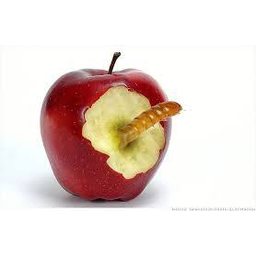

Prediction 2: 0.033022


In [271]:
url2 = 'https://ministryinwords.files.wordpress.com/2015/07/apple-21.jpg?w=584' #Bad
image2 = prepareToPredict(url2)
yhat2 = model.predict(image2)
print("Prediction 2: %f" % yhat2[0][0])

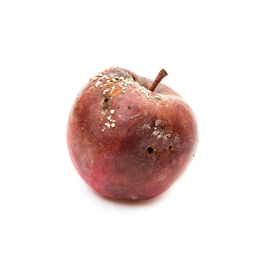

Prediction 3: 0.184956


In [272]:
url3 = 'https://thumbs.dreamstime.com/b/rotten-apple-fungus-bad-worm-holes-isolated-white-background-156641718.jpg' # Bad
image3 = prepareToPredict(url3)
yhat3 = model.predict(image3)
print("Prediction 3: %f" % yhat3[0][0])

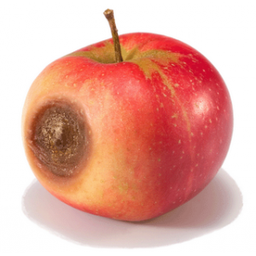

Prediction 4: 0.002276


In [273]:
url4 = 'https://d29rnz06qthrny.cloudfront.net/today/files/2011/11/one-bad-apple-makes-the-barrel-bad-300x295.png'
image4 = prepareToPredict(url4)
yhat4 = model.predict(image4)
print("Prediction 4: %f" % yhat4[0][0])

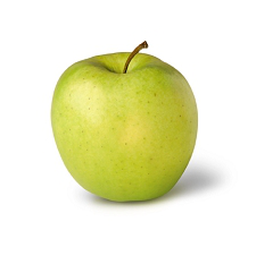

Prediction 5: 0.371954


In [274]:
url5 = 'https://www.honeycrisp.com/assets/images/apples/thumbnails/crispin72_thumbnail.jpg'
image5 = prepareToPredict(url5)
yhat5 = model.predict(image5)
print("Prediction 5: %f" % yhat5[0][0])

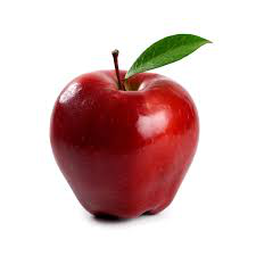

Prediction 6: 0.999503


In [275]:
url6 = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR7uoLTP_mP7Eakw9k4q8KWIbUF_A-OYpmd3Q&usqp=CAU'
image6 = prepareToPredict(url6)
yhat6 = model.predict(image6)
print("Prediction 6: %f" % yhat6[0][0])